# Supervised Learning with scikit-learn (cont.)

### CROSS VALIDATION
Cross-validation (CV) is an iterative process in which each datapoint or cluster of data is given an equal chance at becoming both a training and testing point for the model.

##### Why Cross Validation?
Say you have created and fitted a linear regression model and decide to evaluate its $R^2$ metric. Such metrics are heavily dependent on how the data is split during the train and test-splitting. Due to the random nature of the splitting of data, that $R^2$ metric may not be representative of the model's ability to generalize to unseen data. The solution to this is applying cross-validation which iteratively splits data into training and testing sets multiple times.


Cross-validation works by splitting the data into **folds**. One such fold is designated as test data and the rest as training data. This process is done in an iteration known as a **split**. For each split, the training and testing folds are updated. This ensures that the model has a different set of training and testing folds for each split iteration. At each step, the metric of interest (such as $R^2$) is also calculated. That is, if there have been $n$ splits, then there will be $n$ metrics computed as well. From these values we can compute statistics (e.g. mean, median, confidence intervals, etc.)

CV done with $k$ number of folds is called $k$-fold cross-validation. Also, note that **as $k$ increases**, CV becomes more **computationally expensive**.


In [9]:
import pandas as pd 
import numpy as np
from sklearn.linear_model import LinearRegression

# the KFold class and cross_val_scorer method are required for CV
from sklearn.model_selection import cross_val_score, KFold

In [10]:
# Using the same womens' health dataset
womens_health = pd.read_csv('../Data/diabetes_clean.csv')
womens_health.head()

,pregnancies,glucose,diastolic,triceps,insulin,bmi,dpf,age,diabetes
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
# Setting up multiple linear regression 
predictors_X = womens_health.drop('glucose', axis=1).values
target_y = womens_health['glucose'].values

# Create the CV generator
folds = KFold(n_splits=6, shuffle=True, random_state=12) # Default n_splits is 5. We want 6 folds so we use 6 splits

glc_reg = LinearRegression()

# Get the results of the cross-validation
# Pass the model, predictors, and the CV generator
cv_result = cross_val_score(glc_reg, predictors_X, target_y, cv=folds)

# Note that the score reported will be R^2 since it is the default score for linear regression

In [12]:
# Printing the R^2 scores from cross validation
print(cv_result)

[0.373619   0.27942465 0.38496821 0.33442763 0.24902435 0.29531594]


We can use the scores we've obtained to calculated statistics such as mean score, standard deviation, and the 95% confidence interval.

In [13]:
print(f'CV Average R^2: {np.mean(cv_result)}\nCV R^2 stddev.: {np.std(cv_result)}')
print(f'Score confidence interval: {np.quantile(cv_result, [0.025, 0.975])}')

CV Average R^2: 0.3194632957255576
CV R^2 stddev.: 0.04932122304665104
Score confidence interval: [0.25282439 0.38354956]


### REGULARIZING A LINEAR REGRESSION MODEL

Recall that a linear regression model, like all other ML models, aims to minimize a loss function. That is, by choosing a coefficient $a$ (slope) and $b$ (intercept). However, large coefficients may introduce model overfit. Regularization is done in order to penalize such coefficients. Below are the types of regularized regressions.


##### Ridge Regression
$J(\beta) = SSE + \alpha \cdot \sum_{i=1}^{n} {\beta_i}^2$

Where:
- J($\beta$):   &ensp;&ensp;&ensp; the cost/objective function (function we are minimizing)
- $SSE$:    &ensp;&ensp;&ensp;the Sum of Squared Errors 
- $\alpha$:      &ensp;&ensp;&ensp;&ensp;&ensp;the regularization strength (hyperparameter)
- $n$:          &ensp;&ensp;&ensp;&ensp;&ensp;number of observations
- $\beta$:    &ensp;&ensp;&ensp;&ensp;&ensp;model coefficients/parameters (weights assigned to each feature)
- $\sum_{i=1}^{n} {\beta_i}^2$:    &ensp;&ensp;the L2 penalty term (penalizes large coefficients; squares and sums them. Also ensures penalty is positive.)


                                                                                                                                                    

Intuitively, the L2 penalty somewhat tries to shrink large coefficients towards zero (but rarely exactly zero).



In ridge regression, our aim is to pick the best $\alpha$ for which our model performs best. Note that $\alpha$ controls model complexity and a value of $\alpha = 0$ reduces the expression above into Ordinary Least Squares (OLS), since the regularization term disappears. Thus, a zero value for $\alpha$ may lead to overfitting while a very high value may lead to underfitting. 


Ridge regression is implemented in scikit-learn as shown below.

In [25]:
# Using the womens' health dataset. This time creating a train-test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(predictors_X, target_y, test_size=0.3, random_state=10)

In [33]:
# Import the Ridge class
from sklearn.linear_model import Ridge

# In order to demonstrate the impact of varying values of alpha
# we iterate over different possible values for it and store the corresponding scores
test_scores = []
train_scores = []
alpha_vals = [0.1, 1.0, 10.0, 100.0, 1000.0]   # alpha values set to float since Ridge expects alpha of type float

for val in alpha_vals:
    ridge_mdl = Ridge(alpha=val)
    ridge_mdl.fit(X_train, y_train)      
    train_scores.append(ridge_mdl.score(X_train, y_train))
    test_scores.append(ridge_mdl.score(X_test, y_test))

print(test_scores)
print(train_scores)

[0.2190350811222812, 0.21922962983903327, 0.2198428652237806, 0.19110380340910904, 0.11116010152198696]
[0.3799570054029793, 0.37994592740390143, 0.3790149197475887, 0.35160272462728603, 0.2864818449978622]


Notice that the best $R^2$ possible was obtained with $\alpha = 10$. Also, note that $R_{train}^2 > R_{test}^2$ at low alpha values indicate model overfit. This example, however, is only to show how ridge regression is applied.

##### Lasso Regression

$J(\beta) = SSE + \alpha \cdot \sum_{j=1}^{p} |\beta_j|$

Where:
- $p$: &ensp;&ensp;number of features
- $\sum_{j=1}^{p} |\beta_j|$:    &ensp;&ensp;the L1 penalty term (uses absolute value; non-differentiable at $x = 0$)

In contrast to L2 penalization, the L1 penalty is capable of shrinking coefficients of less important features to zero at high $\alpha$ values. Features that have not been shrunk to zero are selected by the Lasso algorithm.

Also, since the L1 term of lasso regression iterates over features, it is best used when some/many of the features present are irrelevant. The L2 term iterates, on the other hand, is best used when most features are useful as it sums with respect to all observations $n$.

Lasso regression is implemented below.

In [32]:
# Import the Lasso class
from sklearn.linear_model import Lasso

test_scores = []
train_scores = []
# Implementation is similar to ridge regression
for val in alpha_vals:
    lasso_mdl = Lasso(alpha=val)
    lasso_mdl.fit(X_train, y_train)
    train_scores.append(lasso_mdl.score(X_train,y_train))
    test_scores.append(lasso_mdl.score(X_test, y_test))

print(test_scores)
print(train_scores)

[0.22073468508387462, 0.22275653631054781, 0.09204567122971441, 0.0886150752305579, 0.038280697634941685]
[0.37983244992172027, 0.374388344348069, 0.26192198363079244, 0.16891240104249805, 0.060380045884567246]


Observe that for high $\alpha$ values result in absurdly low $R^2$. Also, the best obtained test score is achieved with $\alpha = 1$. Overfitting is once again observed since $R_{train}^2 > R_{test}^2$ for this instance of Lasso regression.


##### Lasso for Feature Selection
Recall earlier that the Lasso algorithm can select important features in a dataset. That is, those features that are not shrunk to zero. Here is a visualization showing how Lasso works on the coefficients for each feature in the womens' health dataset. 

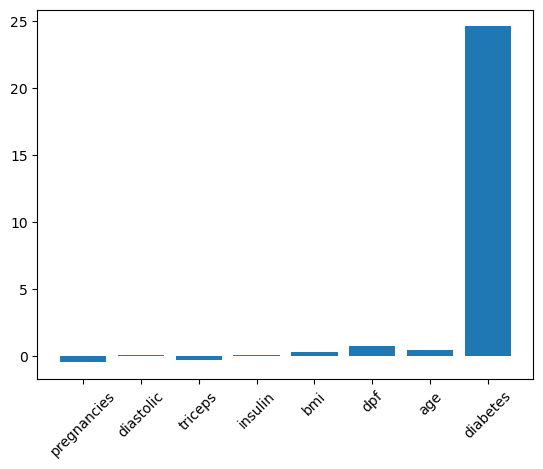

In [39]:
# Using womens' health dataset again
feature_names = womens_health.drop('glucose', axis=1).columns   
lasso_mdl = Lasso(alpha=0.1)   # Setting alpha to 0.1 for now

# Fits the model to the data and extracts the coefficients using .coef_
feature_coefs = lasso_mdl.fit(predictors_X, target_y).coef_

# Visualizing the coefficients
import matplotlib.pyplot as plt
plt.bar(feature_names, feature_coefs)
plt.xticks(rotation=45)
plt.show()

It is shown that the feature `diabetes`, containing binary values, is the most important predictor for the `blood_glucose` target variable.